# MACD algotrading and backtesting

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# MACD packages
import yfinance as yf
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')

## Data collection

In [2]:
# Names of intersted stocks
tickers = ['ABBV', 'PFE', 'BAC', 'COKE', 'SQ',
           'AAPL', 'AMD', 'FDX', 'EBAY', 'AMZN',
           'C', 'F', 'GDX', 'USO']

In [3]:
tickers_df = yf.download(tickers = tickers, start = "2020-01-01", period="max", interval = "1d", group_by = "ticker")
tickers_df.tail()

[*********************100%***********************]  14 of 14 completed


ABBV                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2021-08-30  119.839996  120.900002  119.540001  120.570000  120.570000   
2021-08-31  120.830002  121.169998  120.029999  120.779999  120.779999   
2021-09-01  121.000000  121.529999  106.099998  112.269997  112.269997   
2021-09-02  113.550003  113.739998  110.820000  112.019997  112.019997   
2021-09-03  111.180000  112.070000  111.019997  111.620003  111.620003   

                              SQ                                      ...  \
              Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2021-08-30   3260900  271.000000  273.869995  268.500000  271.920013  ...   
2021-08-31   6021800  273.500000  276.140015  266.260010  268.070007  ...   
2021-09-01  50943200  269.010010  273.149994  267.940002  268.250000  ...   
2021-09-02  14719200  272.369995  274.369995  265.470001  265.940002  ...   
2021-09-03   5364800  266.540009  270.630005  263.679993  269.739990  ...   

                    C                                        PFE             \
                  Low      Close  Adj Close    Volume       Open       High   
Date                                                                          
2021-08-30  71.220001  71.669998  71.669998  12687400  46.200001  47.160000   
2021-08-31  71.330002  71.910004  71.910004  17285900  46.720001  47.139999   
2021-09-01  71.209999  71.309998  71.309998  15114800  46.189999  46.259998   
2021-09-02  70.919998  71.500000  71.500000  13533400  46.480000  46.869999   
2021-09-03  70.650002  71.169998  71.169998  13683300  46.900002  47.029999   

                                                       
                  Low      Close  Adj Close    Volume  
Date                                                   
2021-08-30  46.160000  46.759998  46.759998  25774400  
2021-08-31  45.930000  46.070000  46.070000  34547800  
2021-09-01  45.419998  46.040001  46.040001  32900100  
2021-09-02  46.130001  46.840000  46.840000  26106300  
2021-09-03  46.340000  46.840000  46.840000  20817200  

[5 rows x 84 columns]

## MACD calcualtion and plots

In [4]:
# Calculate MACD data and add to dictionary
macd_list = {}
for ticker in tickers:
    # MACD data
    ewm_fast = tickers_df[ticker, "Close"].ewm(span = 12, adjust = False).mean()
    ewm_slow = tickers_df[ticker, "Close"].ewm(span = 26, adjust = False).mean()
    macd = pd.DataFrame(ewm_fast - ewm_slow)
    macd = macd.rename(columns = {"Close":"macd"})
    # Signal data
    signal = pd.DataFrame(macd[ticker, "macd"].ewm(span = 9, adjust = False).mean()).rename(columns = {"macd":"signal"})
    # Histogram data
    histogram = pd.DataFrame(macd[ticker, "macd"] - signal[ticker, "signal"]).rename(columns = {0:(ticker, "hist")})
    ticker_macd = pd.concat([macd, signal, histogram], join = "inner", axis = 1)
    macd_list[ticker] = ticker_macd

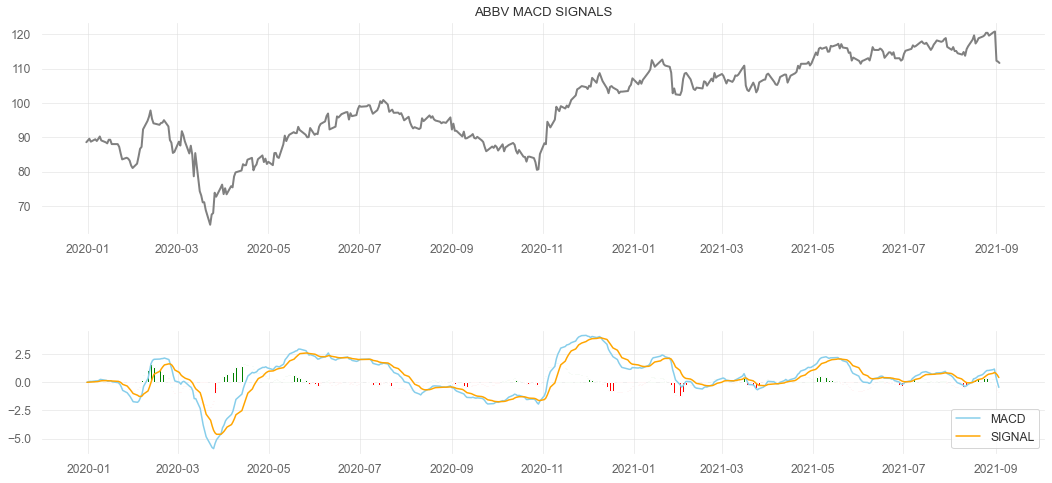

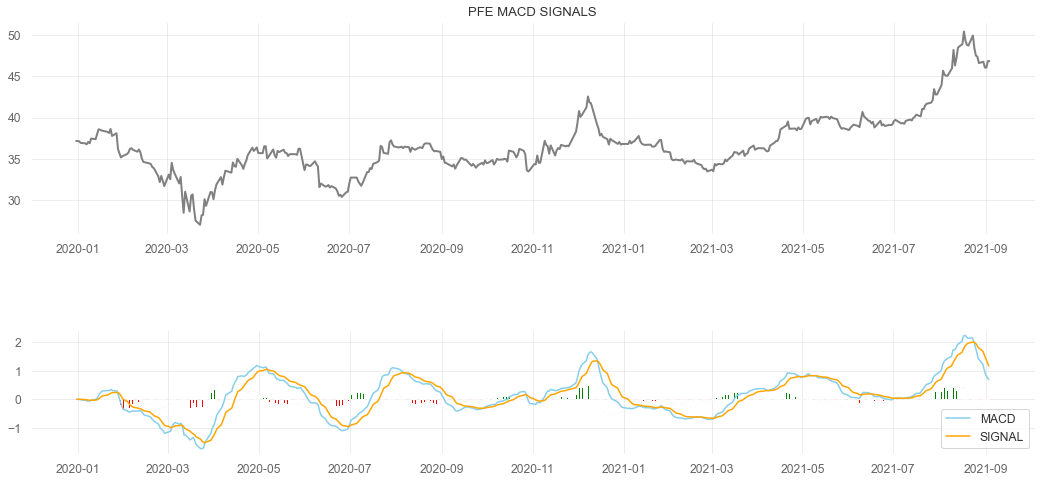

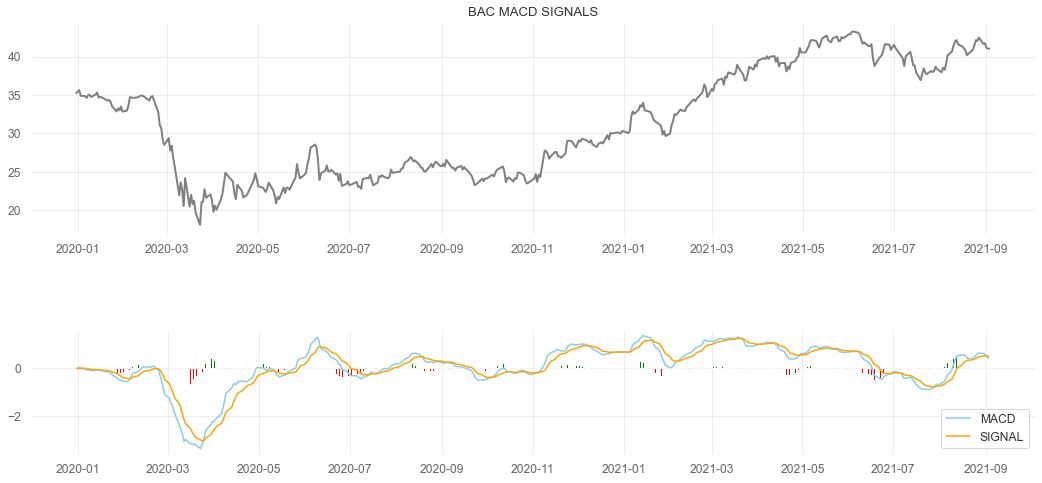

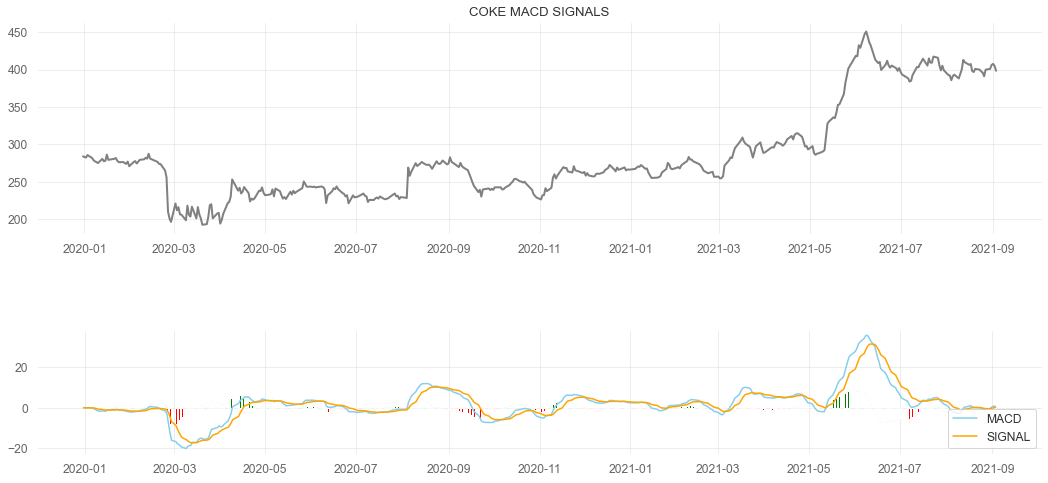

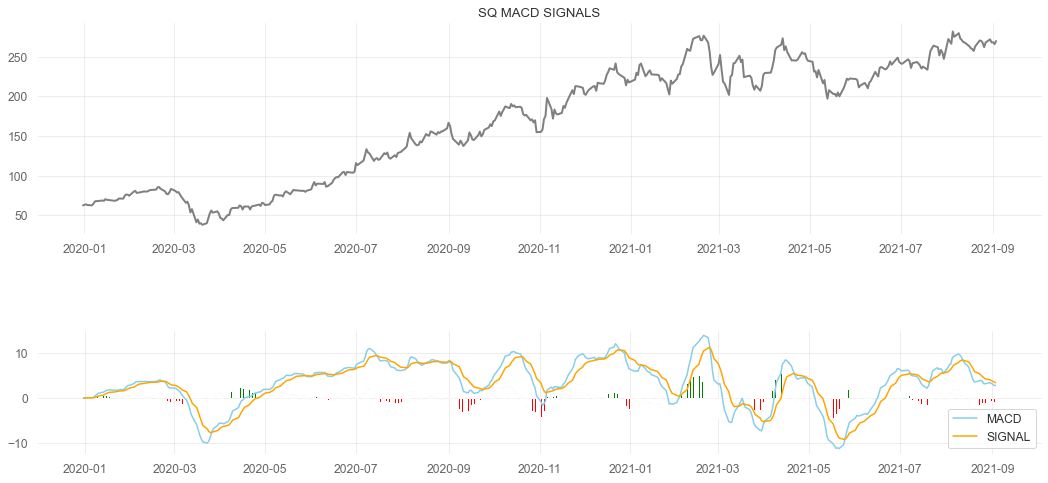

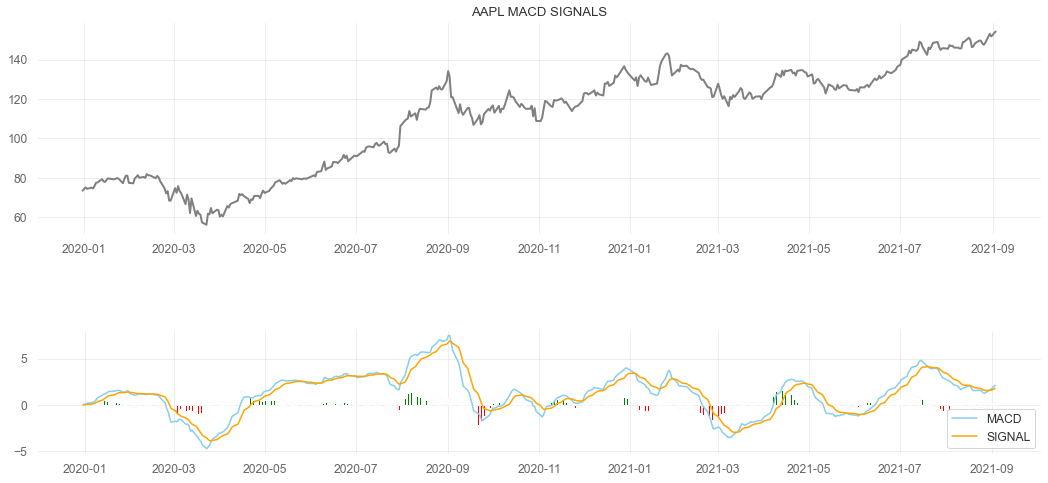

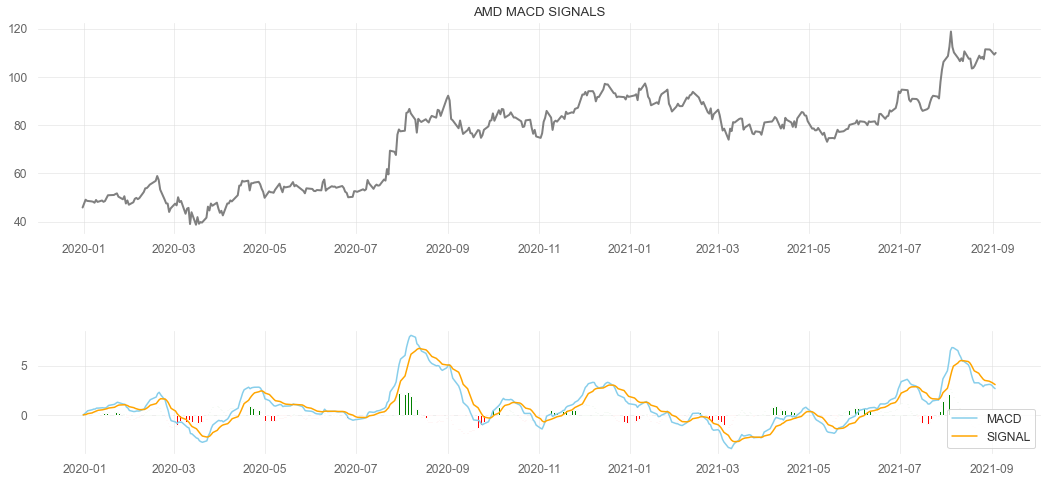

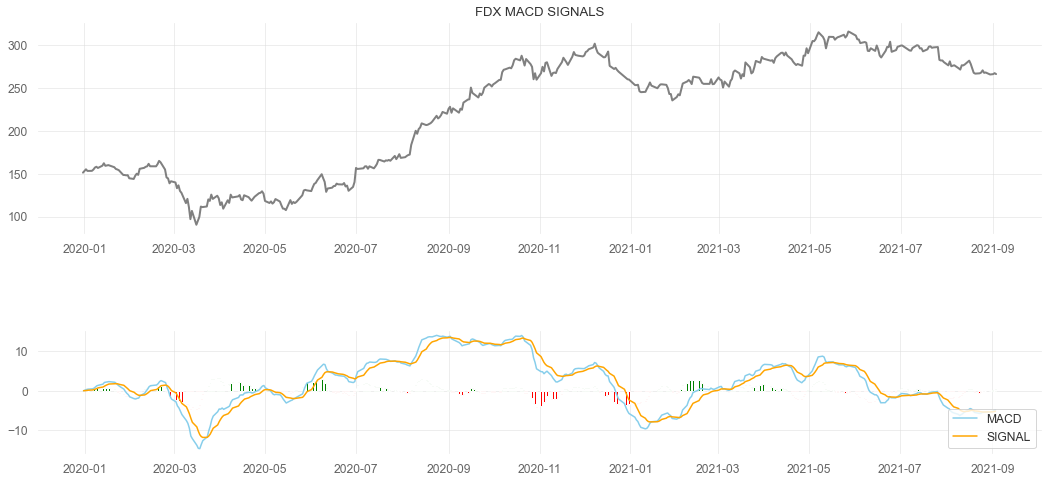

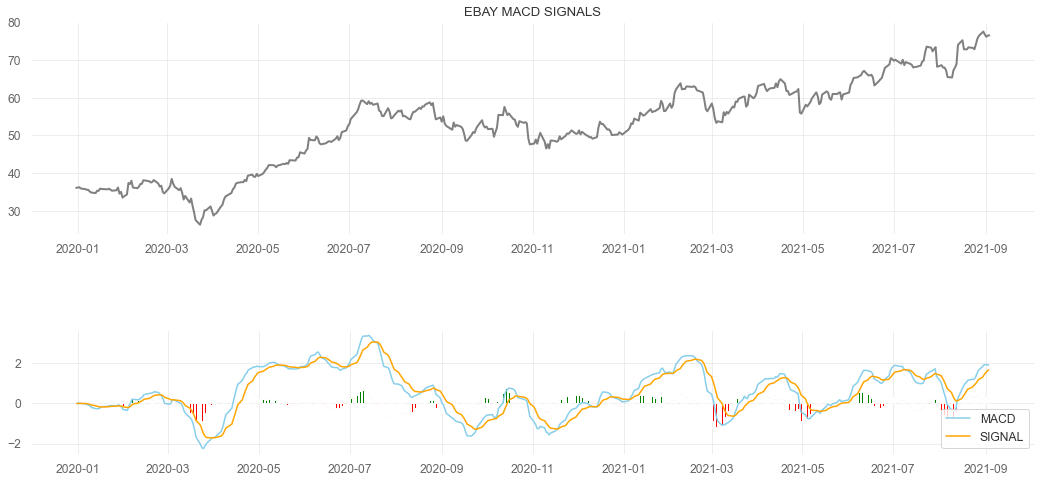

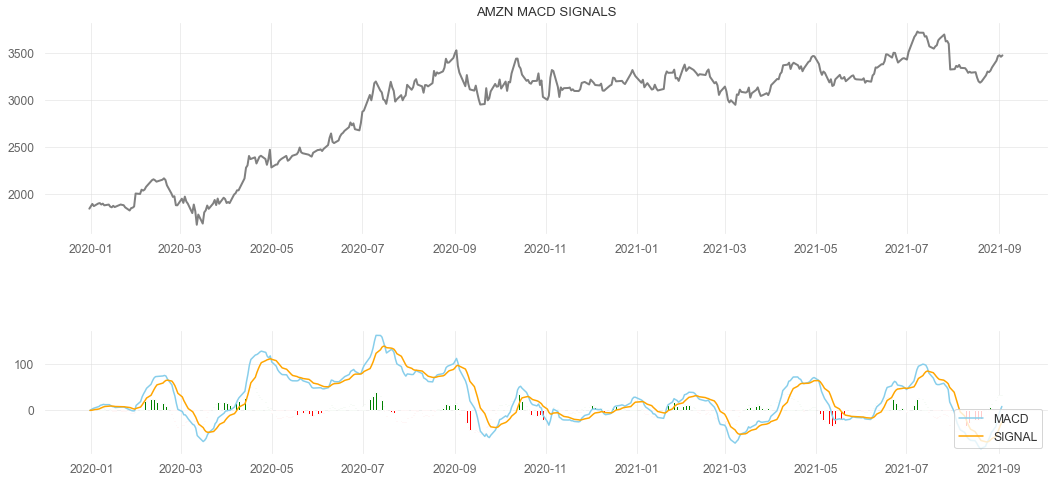

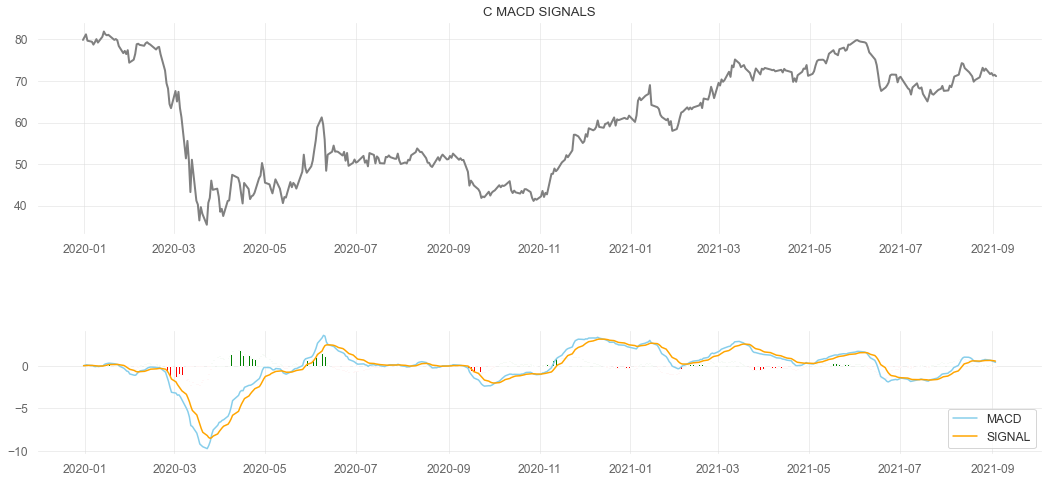

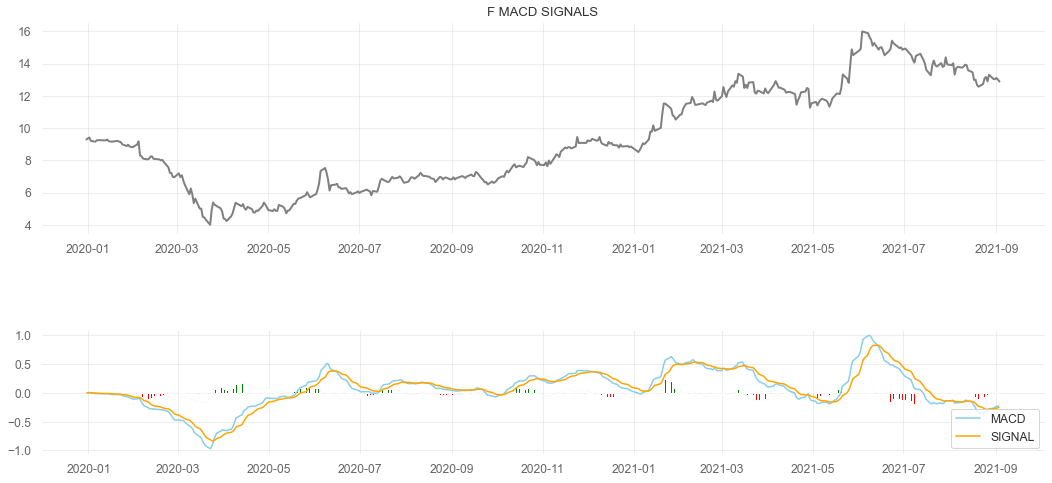

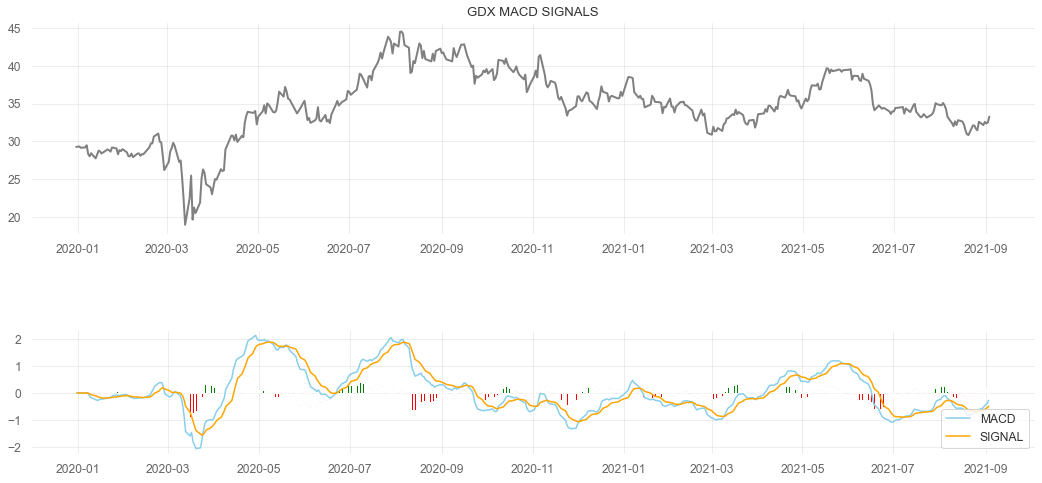

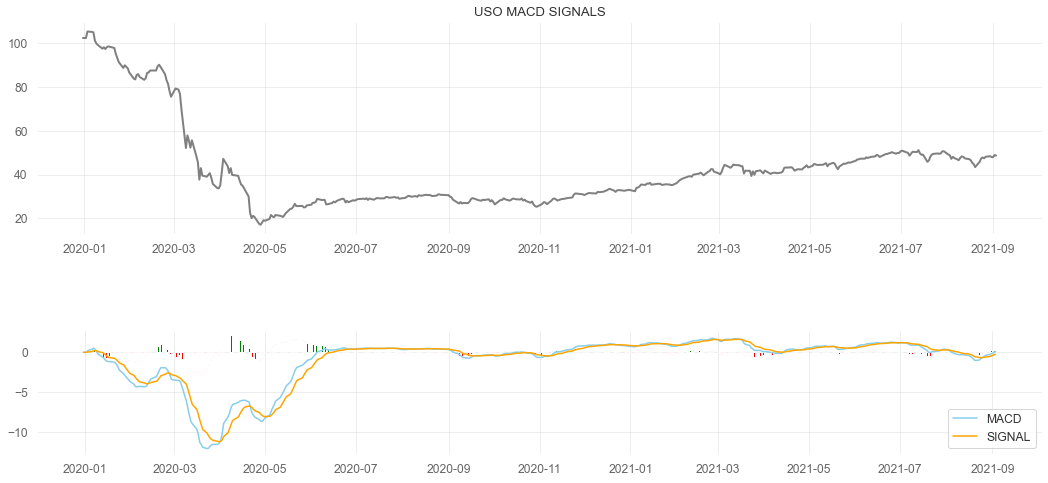

In [6]:
# Plot MACD data per individual stock
for ticker in tickers: 
    plt.rcParams["figure.figsize"] = [18,12]
    
    ax1 = plt.subplot2grid((15,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((15,1), (7,0), rowspan = 3, colspan = 1)

    ax1.plot(tickers_df[ticker]["Close"], color = 'gray', linewidth = 2, label = ticker)
    
    ax1.set_title(f'{ticker} MACD SIGNALS')
    ax2.plot(macd_list[ticker][ticker]['macd'], color = 'skyblue', linewidth = 1.5, label = 'MACD')
    ax2.plot(macd_list[ticker][ticker]['signal'], color = 'orange', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(macd_list[ticker][ticker])):
        if str(macd_list[ticker][ticker]['hist'][i])[0] == '-':
            ax2.bar(macd_list[ticker][ticker].index[i], macd_list[ticker][ticker]['hist'][i], color = 'red')
        else:
            ax2.bar(macd_list[ticker][ticker].index[i], macd_list[ticker][ticker]['hist'][i], color = 'green')
    
    plt.legend(loc = 'lower right')
    #plt.savefig(f"Images/{ticker}_MACD.png", bbox_inches='tight', facecolor='white')
    plt.show()

## Trading Strategy based on MACD

In [7]:
# Create Trading Strategy function
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    # For loop for range of dates
    for i in range(len(data)):
        # Conditional produce signal to buy stock
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        # Conditional produce signal to sell stock
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

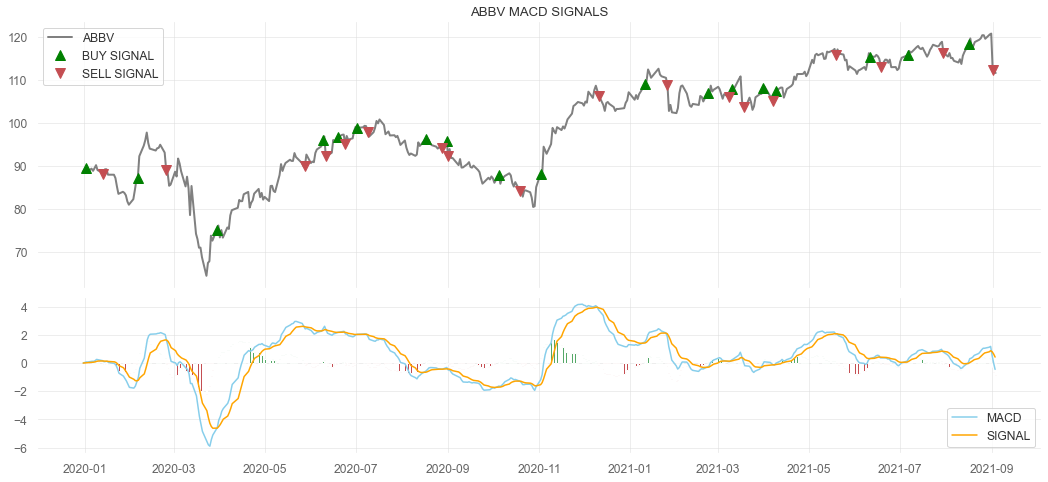

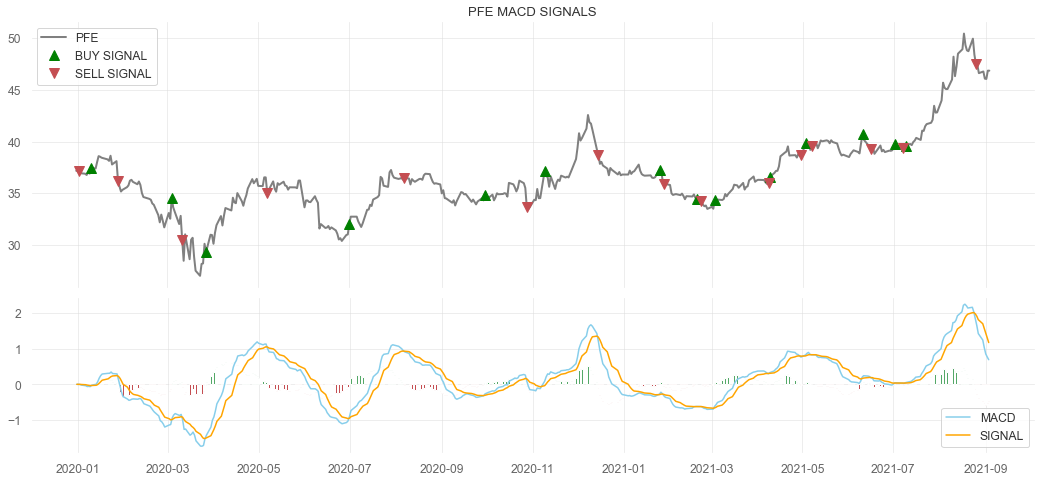

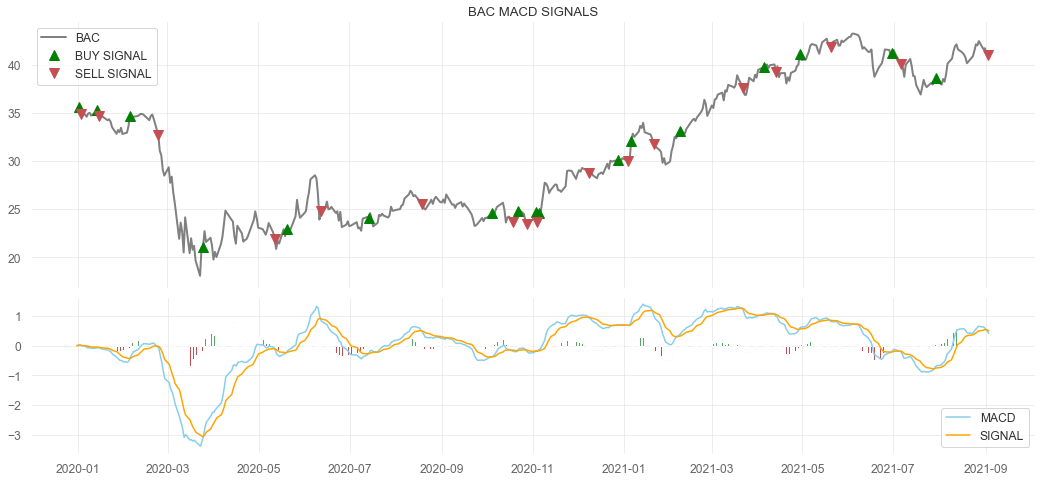

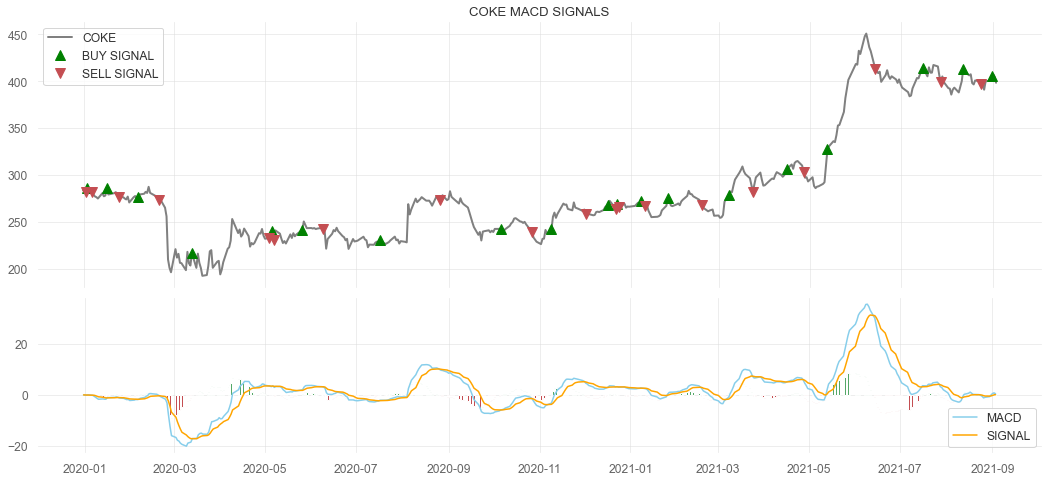

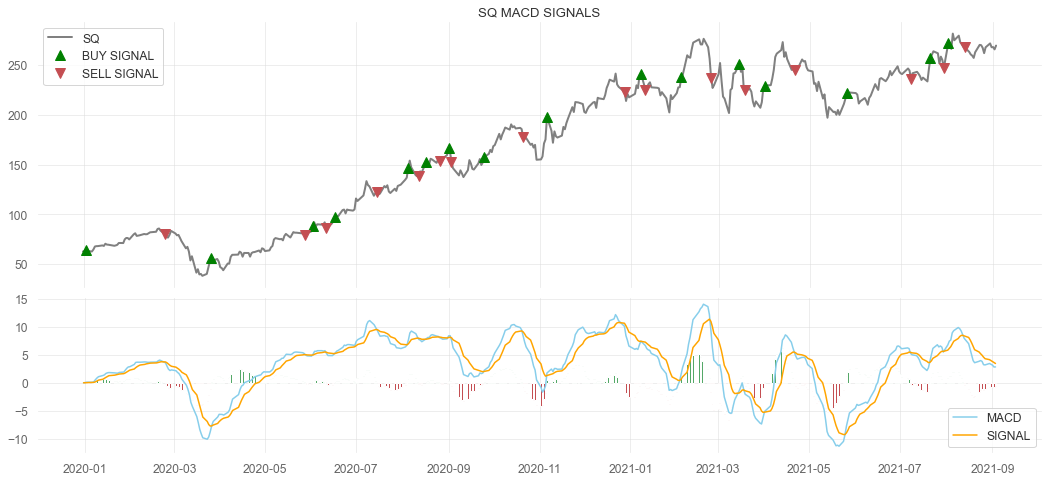

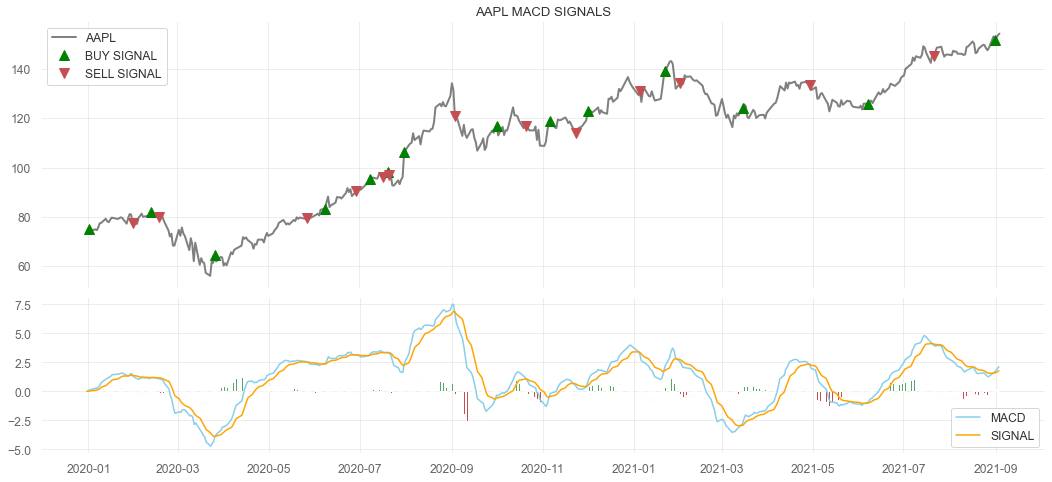

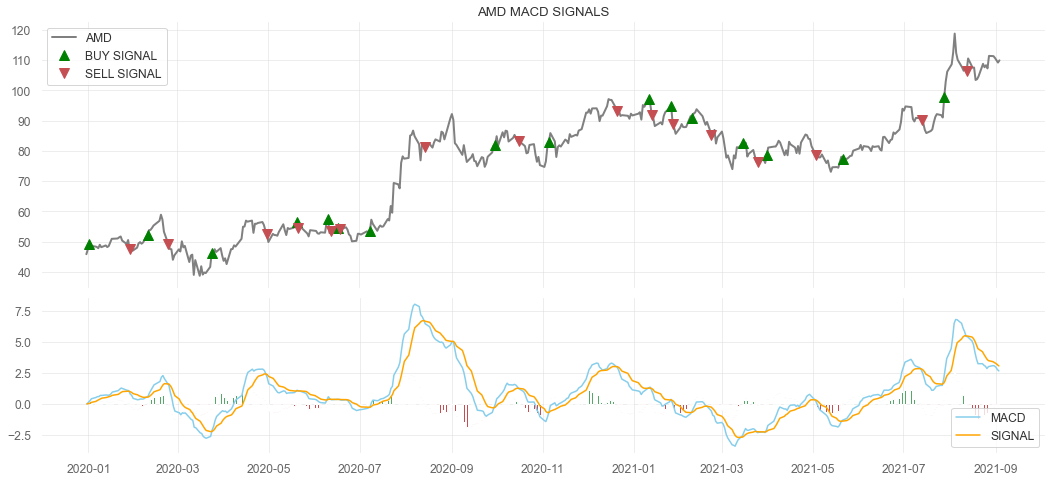

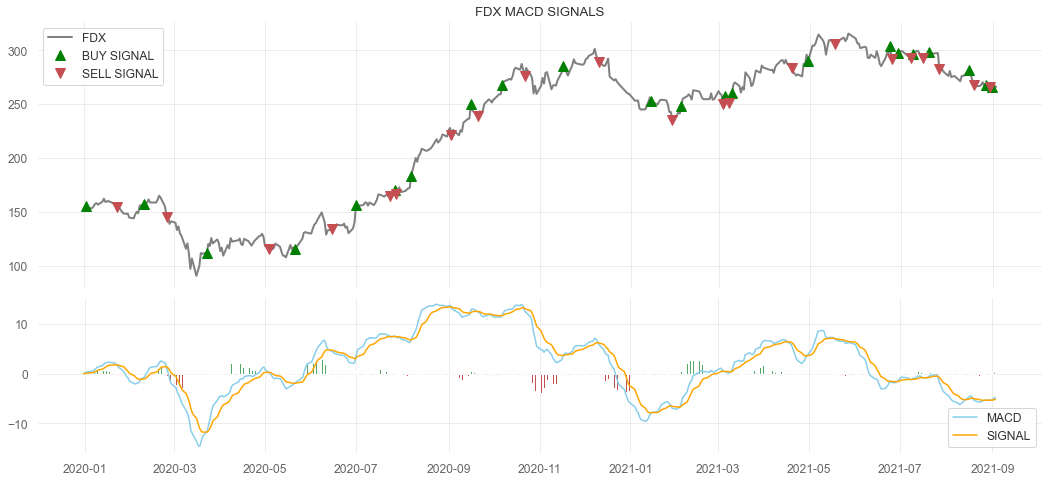

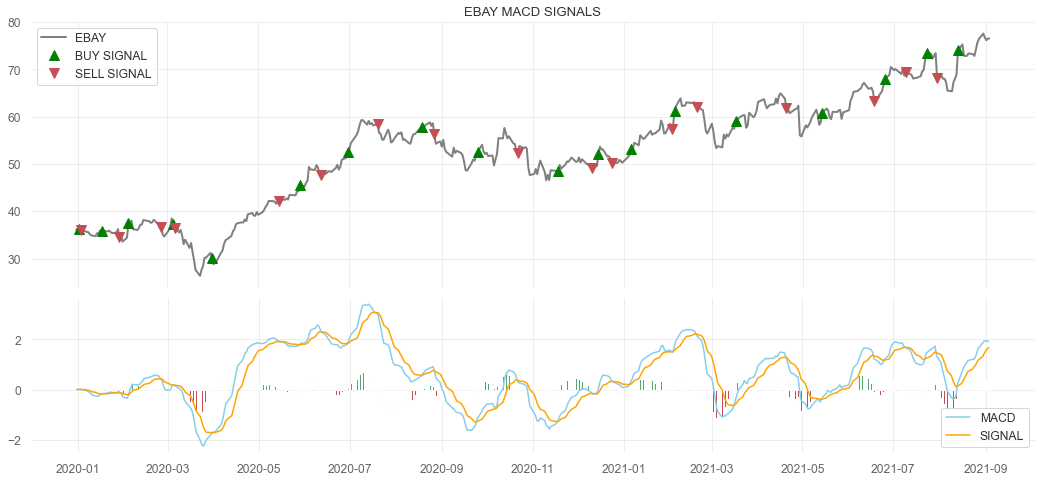

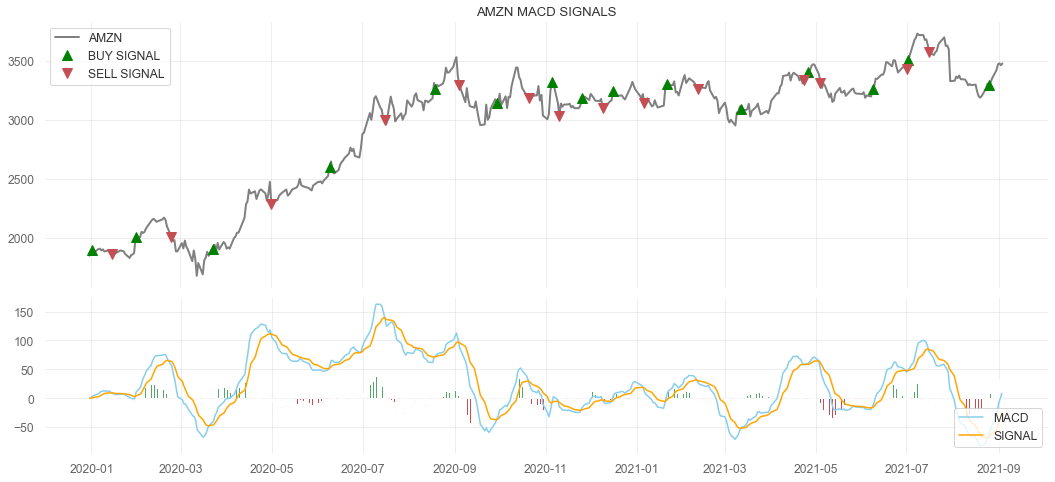

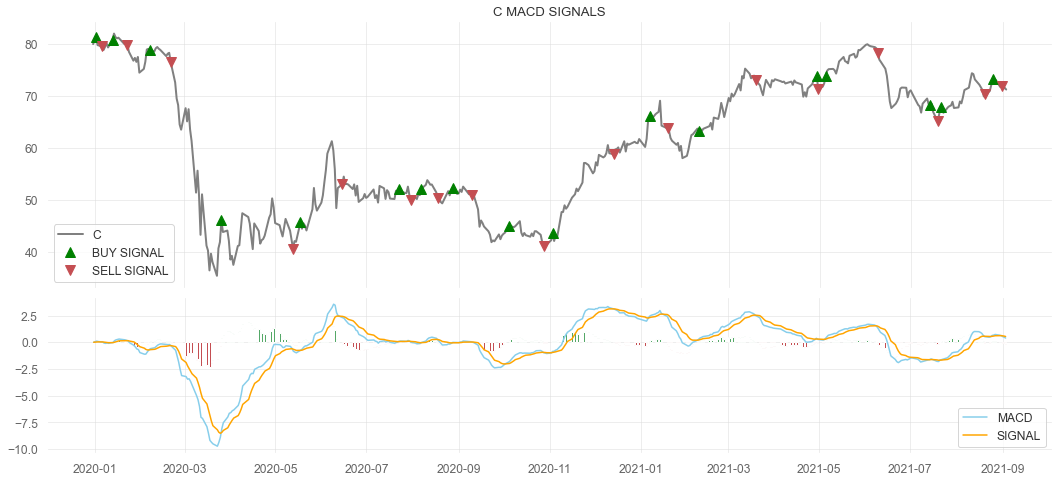

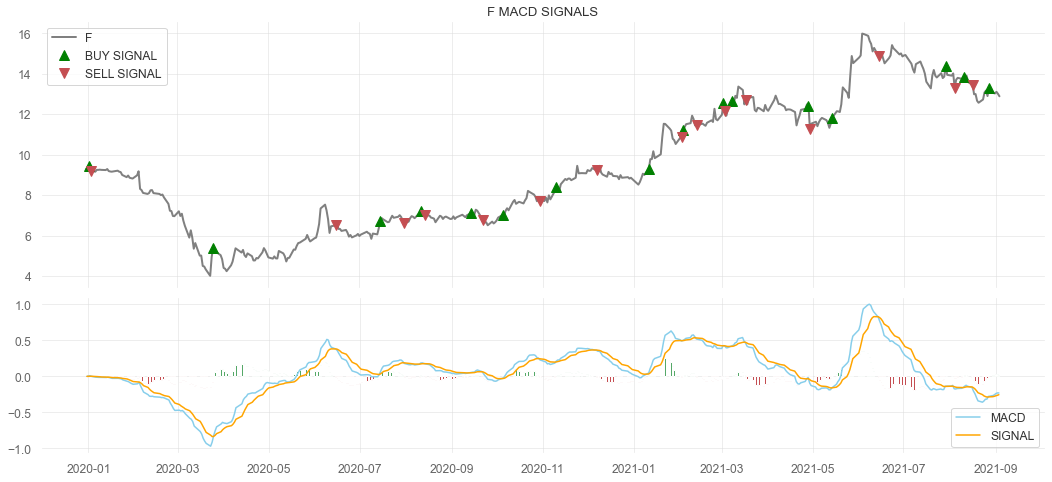

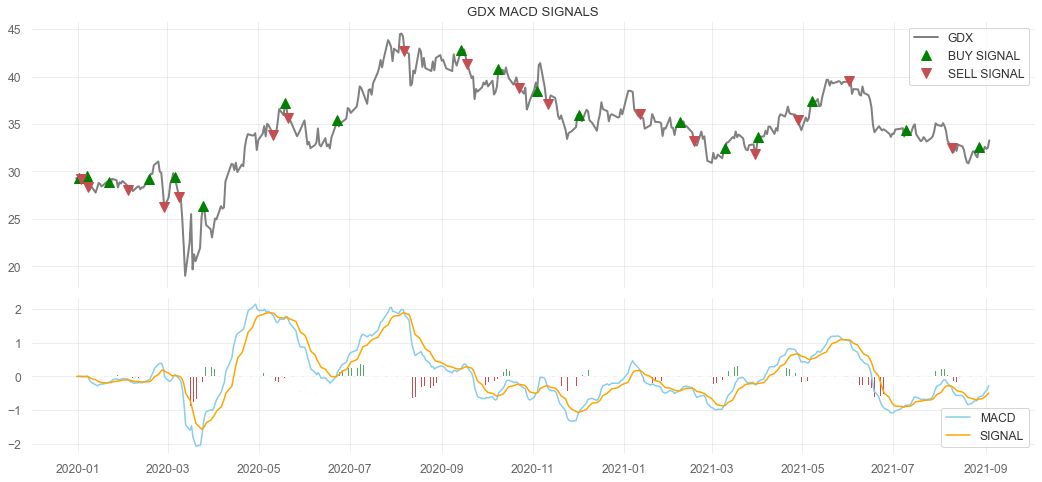

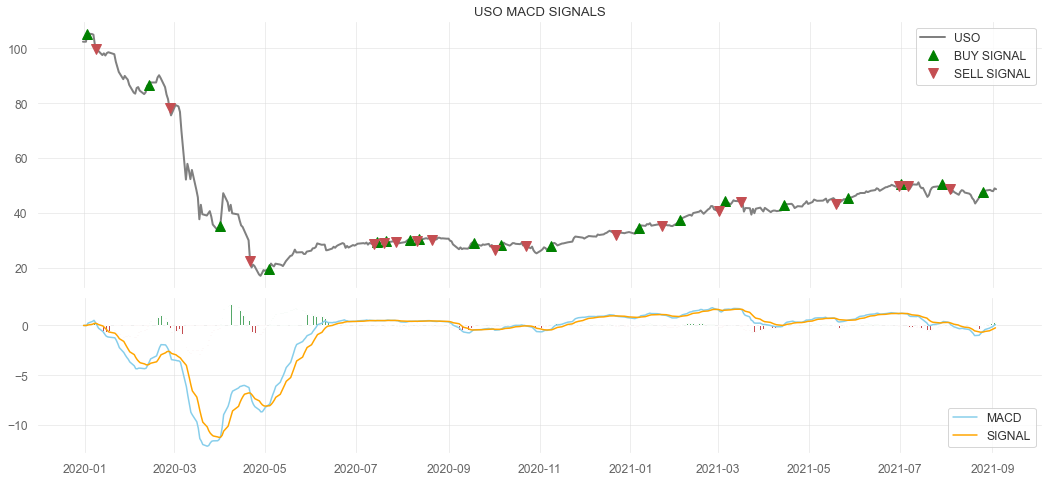

In [9]:
# Run trade strategy and plot buy and sell signals
for ticker in tickers:            
    buy_price, sell_price, macd_signal = implement_macd_strategy(tickers_df[ticker]["Close"], macd_list[ticker][ticker])
    
    plt.rcParams["figure.figsize"] = [18,12]

    ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((12,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(tickers_df[ticker]["Close"], color = 'gray', linewidth = 2, label = ticker)
    ax1.plot(tickers_df[ticker]["Close"].index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
    ax1.plot(tickers_df[ticker]["Close"].index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
    ax1.legend()
    ax1.set_title(f'{ticker} MACD SIGNALS')
    ax2.plot(macd_list[ticker][ticker]['macd'], color = 'skyblue', linewidth = 1.5, label = 'MACD')
    ax2.plot(macd_list[ticker][ticker]['signal'], color = 'orange', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(macd_list[ticker][ticker])):
        if str(macd_list[ticker][ticker]['hist'][i])[0] == '-':
            ax2.bar(macd_list[ticker][ticker].index[i], macd_list[ticker][ticker]['hist'][i], color = 'r')
        else:
            ax2.bar(macd_list[ticker][ticker].index[i], macd_list[ticker][ticker]['hist'][i], color = 'g')
        
    plt.legend(loc = 'lower right')
    #plt.savefig(f"Images/{ticker}_TradeSignal.png", bbox_inches='tight', facecolor='white')
    plt.show()

In [10]:
# Run strategy to create position
stock_strategy = {}

for ticker in tickers:            
    buy_price, sell_price, macd_signal = implement_macd_strategy(tickers_df[ticker]["Close"], macd_list[ticker][ticker])

    position = []
    for i in range(len(macd_signal)):
        if macd_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(tickers_df[ticker]['Close'])):
        if macd_signal[i] == 1:
            position[i] = 1
        elif macd_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    macd = macd_list[ticker][ticker]['macd']
    signal = macd_list[ticker][ticker]['signal']
    close_price = tickers_df[ticker]["Close"]
    macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(tickers_df[ticker]["Close"].index)
    position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(tickers_df[ticker]["Close"].index)

    frames = [close_price, macd, signal, macd_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)

    stock_strategy[ticker] = strategy

## Backtesting

In [11]:
# Create dictionary and populate according to macd_signal
stock_signals = {}

for ticker in tickers:
    entries = []
    exits = []
    for sig in stock_strategy[ticker]["macd_signal"]:
        if sig == -1:
            entries.append("False")
            exits.append("True")
        elif sig == 1:
            entries.append("True")
            exits.append("False")
        else:
            entries.append("False")
            exits.append("False")
    entries = pd.Series(entries, index = tickers_df[ticker]["Close"].index)
    exits = pd.Series(exits, index = tickers_df[ticker]["Close"].index)
    # Change type to bool
    entries = entries == "True"
    exits = exits == "True"
    # Create dataframe
    entries = pd.DataFrame(entries).rename(columns = {0:'entries'}).set_index(tickers_df[ticker]["Close"].index)
    exits = pd.DataFrame(exits).rename(columns = {0:'exits'}).set_index(tickers_df[ticker]["Close"].index)
    close_price = tickers_df[ticker]["Close"]
    frames = [close_price, entries, exits]
    signals = pd.concat(frames, join = 'inner', axis = 1)

    stock_signals[ticker] = signals

## Investing $100,000 into the porfolio

In [12]:
init_cash = 100000

In [13]:
close = vbt.YFData.download(['ABBV',
           'PFE',
           'BAC',
           'COKE',
           'SQ',
           'AAPL',
           'AMD',
           'FDX',
           'EBAY',
           'AMZN',
           'C',
           'F',
           'GDX',
           'USO'], missing_index='drop', start = "2020-01-01").get('Close')
size = pd.DataFrame.vbt.empty_like(close, fill_value=np.nan)
size.iloc[0] = [0.075, 0.075,0.075,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.05,0.05,0.05,0.05]

pf = vbt.Portfolio.from_orders(
    close, 
    size, 
    size_type='targetpercent', 
    group_by=True,  
    cash_sharing=True, init_cash = init_cash  
)

pf.total_profit() 

print(f"The total profit of just holding the stocks is ${pf.total_profit():.2f}")

The total profit of just holding the stocks is $83181.62


In [14]:
pf.asset_value(group_by=False).iloc[-1]

symbol
ABBV    10331.835836
PFE     10132.476098
BAC      9104.890841
COKE    11762.495917
SQ      35916.465303
AAPL    17742.350949
AMD     19965.843274
FDX     14993.741665
EBAY    18061.236995
AMZN    15678.931857
C        4741.135676
F        7047.966645
GDX      5712.732112
USO      1989.513980
Name: 2021-09-03 00:00:00+00:00, dtype: float64

In [15]:
total_profit = []
size = [0.075, 0.075,0.075,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.05,0.05,0.05,0.05]
i = 0
for ticker in tickers:
    # Build portfolio using macd signals
    portfolio = vbt.Portfolio.from_signals(stock_signals[ticker]["Close"], stock_signals[ticker]["entries"], stock_signals[ticker]["exits"], init_cash = init_cash*size[i])

    # Total profit
    total_profit.append(portfolio.total_profit())
    i +=1
    
print(f"The total profit of exercising MACD signals are ${sum(total_profit):.2f}")

The total profit of exercising MACD signals are $44490.67
